In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.optimize import minimize

from numba import njit


In [67]:
# load data set
df = pd.read_excel('Inflation-data.xlsx', sheet_name='fcpi_m')

df = df.set_index('Country Code').T

df = df.iloc[4:-1]

df = df.pct_change(1)*100

df = df[['BRA', 'CHL', 'MEX', 'COL', 'USA', 'HUN', 'CHN', 'JPN', 'ZAF']].dropna()

df = df.apply(lambda x: x-x.mean())

In [68]:
df.index = pd.to_datetime(df.index, format='%Y%m')

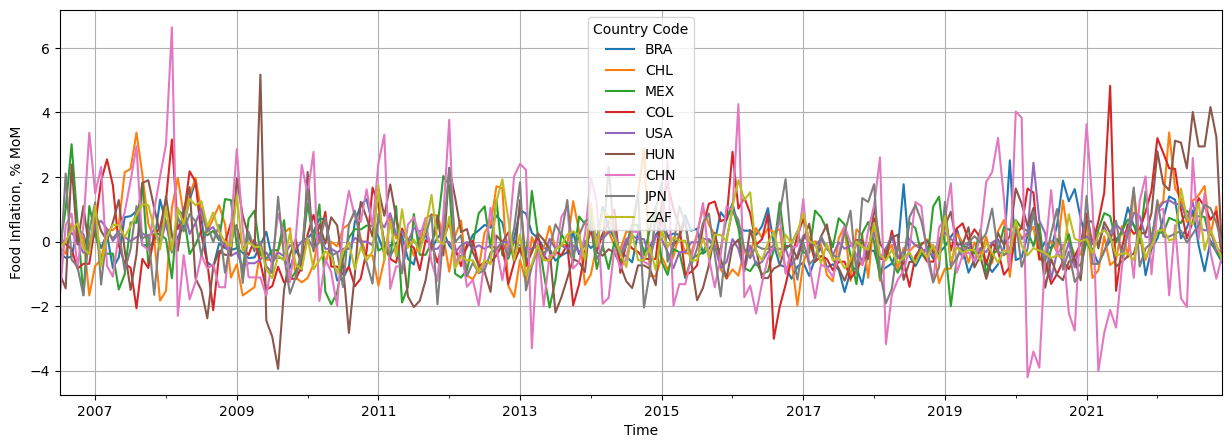

In [69]:
df.plot(figsize=(15,5), grid=True, xlabel='Time', ylabel='Food Inflation, % MoM');

In [70]:
import numpy as np

def kalman(y, Phi, Q, H, R):
    
    """
    Kalman filter for state space mode in the format:
    
    y(t) = H x(t) + u(t),         u(t) sim N(0, R)
    x(t) = Phi x(t-1) + eta(t), eta(t) sim N(0, Q)
    
    y(t): (nobs x nvar)
    H:    (nvar x nstates)
    Phi:  (nstates x nstates)
    Q:    (nvar x nvar)
    R:    (nstates x nstates)
    
    """
    # Obtain dimensions
    nobs, nvar = y.shape
    nstates = Phi.shape[0]

    # Initialize state estimation matrix
    states = np.zeros((nstates, nobs))
    
    # Initialize state estimate and error covariance
    xtm1tm1 = np.zeros((nstates, 1))
    Ptm1tm1 = np.linalg.solve(np.eye(nstates**2) - np.kron(Phi, Phi), Q.reshape((nstates**2, 1))).reshape((nstates, nstates))

    # Initialize log-likelihood
    loglike = 0.0

    # Kalman filter recursion
    for t in range(nobs):
        # Propagation step: Predict state estimate and error covariance
        xttm1 = np.dot(Phi, xtm1tm1)
        Pttm1 = np.dot(np.dot(Phi, Ptm1tm1), Phi.T) + Q

        # Prediction step: Store predicted state estimate and error covariance for each variable
        xttim1 = xttm1
        Pttim1 = Pttm1

        # Correction step for each variable
        for i in range(nvar):
            # Calculate predicted measurement and innovation
            yhat = np.dot(H[i:i+1, :], xttim1)
            uhat = y[t, i:i+1] - yhat
            Vhat = np.dot(np.dot(H[i:i+1, :], Pttim1), H[i:i+1, :].T) + R[i, i]
            
#             if Vhat==0:
#                 Vhat=1
            if Vhat > 0:
                # Calculate log-likelihood of the observation
                loglike += -0.5 * (np.log(2 * np.pi) + np.log(Vhat) + (uhat**2) / Vhat)

            # Calculate Kalman gain and update state estimate and error covariance
            K = np.dot(Pttim1, H[i:i+1, :].T) / Vhat
            xttim1 = xttim1 + np.dot(K, uhat)
            Pttim1 = Pttim1 - np.dot(np.dot(K, H[i:i+1, :]), Pttim1)

        # Update previous state estimate and error covariance
        xtm1tm1 = xttim1
        Ptm1tm1 = Pttim1

        # Store estimated state at current time step
        states[:, t] = xtm1tm1.T

    # Return log-likelihood and estimated states
    return loglike, states


Common factor model

$y_{it} = \lambda_{i} f_t + e_{it}$

$f_t = a_1 f_{t-1} + a_2 f_{t-2} + a_3 f_{t-3} + a_4 f_{t-4} + u(t), \quad u(t) \sim N(0,\sigma_u^2)$

$e_{it} = \rho_i e_{it-1} + w_t, \quad w_t \sim N(0,\sigma_w^2)$

Matrix format:

 - Measurement equation
\begin{equation}
\begin{bmatrix}
y_{1t} \\
y_{2t} \\
y_{3t} \\
y_{4t} \\
\end{bmatrix} = 
\begin{bmatrix}
\lambda_{1} & 0 & 0 & 0 & 1 & 0 & 0 & 0
\\
\lambda_{2} & 0 & 0 & 0 & 0 & 1 & 0 & 0
\\
\lambda_{3} & 0 & 0 & 0 & 0 & 0 & 1 & 0
\\
\lambda_{4} & 0 & 0 & 0 & 0 & 0 & 0 & 1
\\
\end{bmatrix}
\begin{bmatrix}
f_{t}\\
f_{t-1}\\
f_{t-2}\\
f_{t-3}\\
e_{1t}\\
e_{2t}\\
e_{3t}\\
e_{4t}\\
\end{bmatrix}
\end{equation}

 - State Equation
 
\begin{equation}
\begin{bmatrix}
f_{t}\\
f_{t-1}\\
f_{t-2}\\
f_{t-3}\\
e_{1t}\\
e_{2t}\\
e_{3t}\\
e_{4t}
\end{bmatrix}=
\begin{bmatrix}
a_{1} & a_{2} & a_{3} & a_{4} & 0 & 0 & 0 & 0\\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & \rho_1 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & \rho_2 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & \rho_3 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \rho_4
\end{bmatrix}
\begin{bmatrix}
f_{t-1}\\
f_{t-2}\\
f_{t-3}\\
f_{t-4}\\
e_{1t-1}\\
e_{2t-1}\\
e_{3t-1}\\
e_{4t-1}
\end{bmatrix}+
\begin{bmatrix}
u_{t}\\
0 \\
0\\
0\\
w_{1t}\\
w_{2t}\\
w_{3t}\\
w_{4t}
\end{bmatrix}
\end{equation}

\begin{equation}
R=
\begin{bmatrix} 
\sigma_{u}^2 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & \sigma_{w1}^2 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & \sigma_{w2}^2 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & \sigma_{w3}^2 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma_{w4}^2
\end{bmatrix}
\end{equation}

$\theta = (\lambda_1, \lambda_2, \lambda_3, \lambda_4, a_1, a_2, a_3, a_4, \rho_1, \rho_2, \rho_3, \rho_4,
\sigma_u, \sigma_1, \sigma_2, \sigma_3, \sigma_4)$

In [71]:
def diagonal_concat(A, B):
    # Adjust dimensions of A and B
    max_rows = max(A.shape[0], B.shape[0])
    max_cols = max(A.shape[1], B.shape[1])
    A_pad = np.pad(A, ((0, max_rows - A.shape[0]), (0, max_cols - A.shape[1])), mode='constant')
    B_pad = np.pad(B, ((0, max_rows - B.shape[0]), (0, max_cols - B.shape[1])), mode='constant')
    
    # Perform diagonal concatenation
    result = np.block([[A_pad, np.zeros_like(B_pad)],
                       [np.zeros_like(A_pad), B_pad]])
    
    return result

def state_space(params, endog):
    
    n_endog = endog.shape[1]
    p = 4
    
    # design matrix
    H = np.c_[params[:n_endog], np.zeros((n_endog, 3)), np.eye(n_endog)]
    
    # Define the submatrices
    tmpA = np.r_[params[n_endog:n_endog+p], np.zeros(n_endog)].reshape((1, p+n_endog))
    tmpB = np.c_[np.eye(p-1), np.zeros((p-1, n_endog+1))]
    tmpC = np.c_[np.zeros((n_endog, p)), np.diag(params[n_endog+p:2*n_endog+p])]
    
    # transition matrix
    Phi = np.r_[tmpA, tmpB, tmpC]
    
    # observation covariance
    R = np.zeros((n_endog, n_endog))
    
    # state covariance
    tmp1 = np.zeros((p, p))
    tmp1[0,0] = params[2*n_endog+p]**2
    
    tmp2 = np.diag(params[-n_endog:]**2)
    
    tmp3 = np.c_[tmp1, np.zeros((p, n_endog))]
    tmp4 = np.c_[np.zeros((n_endog, p)), tmp2]
    
    Q = np.r_[tmp3, tmp4]
    
    
    return H, Phi, Q, R
    


In [72]:
3*df.shape[1]+5


32

In [74]:
# params = np.array([.1, .2, .3, .4, .95, .2, .3, .4, .1, .2, .3, .4, .1, .1, .1, .1, .1])
params = np.random.uniform(size=3*df.shape[1]+5)
H, Phi, Q, R = state_space(params, df.values)

In [75]:
ll, ss = kalman(df.values, Phi, Q, H, R)

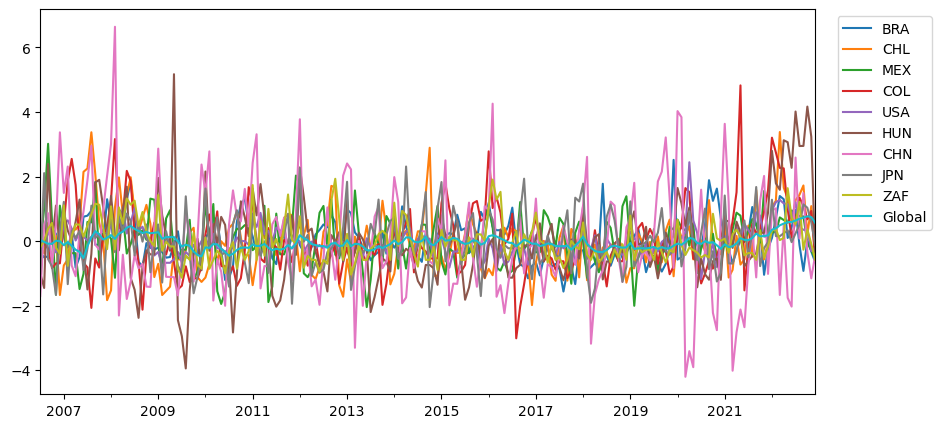

In [93]:
GlobalFactor = pd.DataFrame(ss[0,:], index = df.index, columns=['Global_Factor'])

df_aux = df.copy()
df_aux['Global'] = ss[0,:]

ax = df_aux.plot(figsize=(10,5))

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# Show the plot
plt.show()

In [77]:
def neg_loglike(params, endog):
    
    H, Phi, Q, R = state_space(params, df.values)    
    
    ll, ss = kalman(df.values, Phi, Q, H, R)    
    
    return -ll

In [99]:
# Minimization using scipy.optimize.minimize
method='Nelder-Mead'
result = minimize(neg_loglike, params, args=(df.values,), method=method)

optimized_params = result.x

print("Optimized parameters: \n", optimized_params)

Optimized parameters: 
 [ 0.64796341  0.38876849  0.97883263  0.80842116  0.00652234  0.32429862
 -0.57628924  1.73043453  0.2913363   0.76603541  0.39031876  0.00477016
 -0.04995342  0.4767698   0.43664918  0.11729231  0.41832999  0.3128987
 -0.05834755  0.31612353  0.02366189  0.32898477  0.0517687   0.66687766
  1.0604493   0.71432621  0.87434942  0.36376161  1.04316038  1.41731427
  0.83934957  0.61960542]


In [100]:
H, Phi, Q, R = state_space(optimized_params, df.values)

ll, ss = kalman(df.values, Phi, Q, H, R)

In [101]:
GlobalFactor = pd.DataFrame(ss.T, index = df.index)

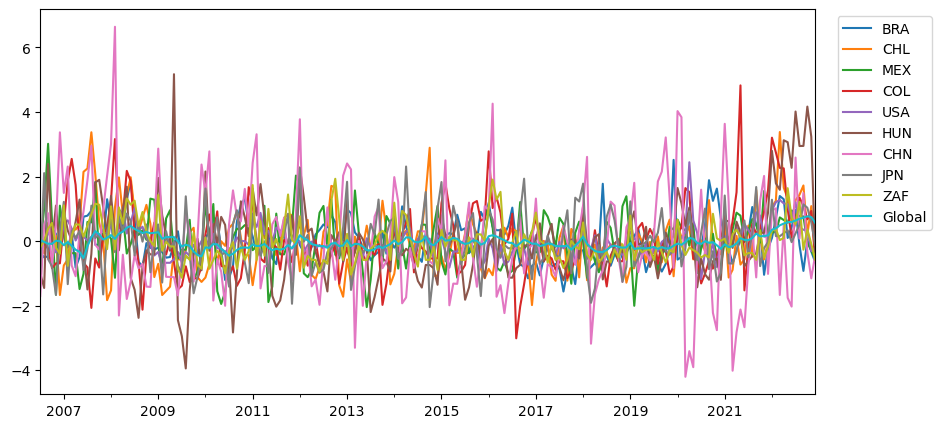

In [102]:
GlobalFactor = pd.DataFrame(ss[0,:], index = df.index, columns=['Global_Factor'])

df_aux = df.copy()
df_aux['Global'] = ss[0,:]


ax = df_aux.plot(figsize=(10,5))

# Move the legend outside the plot box
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# Show the plot
plt.show()

In [86]:
factors = pd.concat( [  GlobalFactor*optimized_params[i] for i in range(df.shape[1])], axis=1)

In [87]:
factors.columns=['Global_Factor_' + x for x in df.columns]

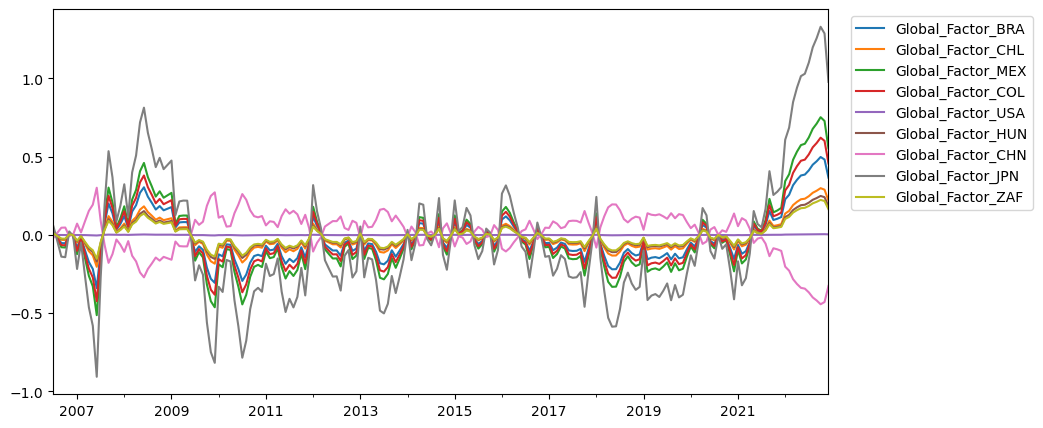

In [90]:
ax = factors.plot(figsize=(10,5))

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# Show the plot
plt.show()